In [2]:
# Imports

import keras # For the neural network
import csv # For the input data
import cv2 # For loading images

import random
#from skimage import transform, img_as_ubyte
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
# Visualizations will be shown in the notebook.
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})

linux_sim_dir = '/home/mach1uvnc/carnd/CarND-Behavioral-Cloning-P3-master/linux_sim/'
recordings_dir = linux_sim_dir+'recordings/'
#all_recordings = ['track_1','track_1b','track_2','track_2b']
all_recordings = ['track_2','track_2b']

In [3]:
# CSV Format:
# Center Image, Left Image, Right Image, Steering (-1,1), Throttle (0,1), Brake (0), Speed (0,30)

def load_csv(recording):
    lines = []
    with open(recordings_dir+recording+"/driving_log.csv") as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
    return lines

def load_image(recording,filename):
    source_file = filename.split("/")[-1] # get just the filename
    source_path = recordings_dir+recording+"/IMG/"+source_file # append it to new directory
    imageBGR = cv2.imread(source_path) # read in the image
    imageRGB = cv2.cvtColor(imageBGR,cv2.COLOR_BGR2RGB) # Convert to match drive.py - RGB
    return imageRGB

def load_data(recording,csvlines,addLeft=True,addRight=True,corr_factor=0.4,addLRFlip=True):
    images = []
    steerings = []
    
    for line in csvlines:
        steering = float(line[3])
        # Center Camera
        steerings.append(steering)
        images.append(load_image(recording,line[0]))
        
        if addLeft:
            # Left Camera
            steerings.append(steering + corr_factor)
            images.append(load_image(recording,line[1]))
            
        if addRight:
            # Right Camera
            steerings.append(steering - corr_factor)
            images.append(load_image(recording,line[2]))
    
    if addLRFlip:
        pass
    
    return images, steerings


In [ ]:
# Load and Preview Data
rec0 = all_recordings[0]
rec0_csv = load_csv(rec0)
X_data, y_data = load_data(rec0,rec0_csv)

rec1 = all_recordings[1]
rec1_csv = load_csv(rec1)
rec1_images, rec1_meas = load_data(rec1, rec1_csv)
X_data += rec1_images
y_data += rec1_meas
del rec1_images, rec1_meas

print (len(rec0_csv),len(rec1_csv),len(X_data),len(y_data))

In [ ]:
for img_idx in random.sample(list(range(len(X_data))),10):
    plt.figure()
    plt.imshow(X_data[img_idx])
    plt.axis('off')
    plt.title('Index: %d  Steering: %.3f' % (img_idx,y_data[img_idx]))


In [17]:
X_data = np.asarray(X_data)
y_data = np.asarray(y_data)


(29367, 160, 320, 3) 29367
(58734, 160, 320, 3)


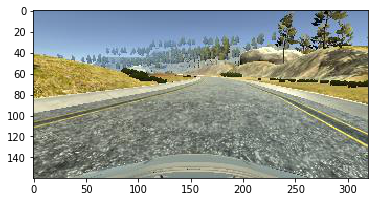

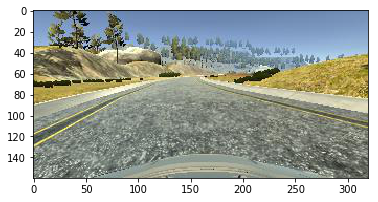

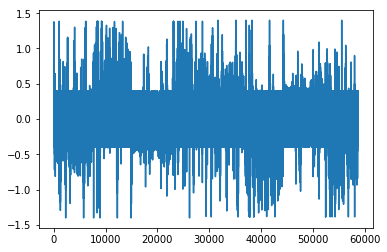

In [18]:
# Add mirror image version to better generalize

#X_data_mirrored = np.copy(X_data)
#print (X_data[0].shape)
#plt.figure()
#plt.imshow(X_data[0])
#plt.figure()
#plt.imshow(X_data[0][:,::-1,:])
orig_len = len(X_data)
X_data_mirrored = [X_data[i][:,::-1,:] for i in range(len(X_data))]
y_data_mirrored = np.copy(y_data)*-1
print(X_data.shape,len(X_data_mirrored))
X_data = np.asarray(list(X_data)+X_data_mirrored)
y_data = np.asarray(list(y_data)+list(y_data_mirrored))
print(X_data.shape)
plt.figure()
plt.imshow(X_data[0])
plt.figure()
plt.imshow(X_data[orig_len])
plt.figure()
plt.plot(y_data)

In [32]:
# Build the Neural Network using Keras
from keras.models import Sequential, Model
from keras.layers import Input,Flatten, Dense, Activation, Lambda, MaxPooling2D, Dropout
from keras.layers import Merge, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.normalization import BatchNormalization

model = Sequential()
model.add(Cropping2D(cropping=((50,20),(0,0)),input_shape=X_data[0].shape))
model.add(Lambda(lambda x: (x / 255.0) - 0.5))
#model.add(BatchNormalization(input_shape=X_data[0].shape))

# Simple Model - functions fairly well, but hugs the right and eventually ends up stuck on a curb
if 0:
    model.add(Flatten())
    
if 1:
    model.add(Convolution2D(8,5,5,activation='relu'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(8,5,5,activation='relu'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(8,5,5,activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(120,activation='relu'))
    model.add(Dense(84,activation='relu'))

model.add(Dense(1))



In [33]:
if 0:
    from keras.layers import merge

    a = Input(shape=X_data[0].shape)
    n = BatchNormalization()(a)
    c1 = Convolution2D(32,160,1,activation='relu')(n)
    c2 = Convolution2D(32,1,320,activation='relu')(n)
    f1 = Flatten()(c1)
    f2 = Flatten()(c2)
    f = merge([f1,f2],mode='concat',concat_axis=1) #(f1,f2)
    b = Dense(1)(f)
    model = Model(input=a,output=b)

In [34]:
# Build Training Code
model.compile(loss='mse', optimizer='adam')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_3 (Cropping2D)        (None, 90, 320, 3)    0           cropping2d_input_3[0][0]         
____________________________________________________________________________________________________
lambda_5 (Lambda)                (None, 90, 320, 3)    0           cropping2d_3[0][0]               
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 86, 316, 8)    608         lambda_5[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_13 (MaxPooling2D)   (None, 43, 158, 8)    0           convolution2d_13[0][0]           
___________________________________________________________________________________________

In [35]:
# Train and Validate
cb_save_best = keras.callbacks.ModelCheckpoint("model.h5",verbose=1,save_best_only=True)
hist_object = model.fit(X_data,y_data, validation_split=0.2, shuffle=True, nb_epoch=3, callbacks=[cb_save_best])

Train on 46987 samples, validate on 11747 samples
Epoch 1/3
46987/46987 [==============================] - 28s - loss: 0.0537 - val_loss: 0.0503
Epoch 2/3
46987/46987 [==============================] - 33s - loss: 0.0452 - val_loss: 0.0518
Epoch 3/3
46987/46987 [==============================] - 35s - loss: 0.0420 - val_loss: 0.0552
